## NLP for Yelp Reviews

In [0]:
!pip install pandas_profiling


In [0]:
# importing required packages

import pandas_profiling
import numpy as np
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import seaborn as sns
import re, string
import sys
import time
import collections

In [3]:
# importing the data
df = pd.read_parquet('review.parquet')

df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
609090,IfFo03nj-PQGTzTdxH8vWA,SxrGc9Qv8b_DWo6DZOeyng,FvVSy2r7_zDEhZWqLgjXNQ,3,0,2,0,The food was great no denying that. I'm trying...,2012-12-02 20:46:30
6460377,L46X3SlvO88xtlusGr1hFg,HOzgd-a-kAiVZappPn5yGA,ERfGoZcgrmF8p89FIs9_TA,5,2,0,1,"Delivered as promised, when promised!\n Excell...",2015-01-11 18:53:04
562100,EcxvP_LcXS2MGgxvNXwCwg,hmqaQ_60rCJi86ur1kYg8g,m65oi2C7b1CJM7DaXbFi-g,5,2,1,1,Came by again with a friend just to hang out. ...,2018-01-06 06:53:10
5339718,a1q77QOPmEJK75FgdfEjDA,qAeiX_1IOEjr56QjRjaBxA,RV__lDpb_Vo4SmSL2r5ezA,5,0,1,1,I called Real Fast Auto Glass to get the winds...,2015-05-12 15:25:27
2958710,gsPiT4oi6rdj9MZt8rfm7w,pFfZdrY_EbDlTxEwKbZl3A,YCoLBgh973QSp-OmnwMWSg,2,2,2,1,"Terrible shuttle service, pretty good service ...",2011-07-13 14:11:37


In [4]:
# descriptive statistics
df.describe()

,stars,useful,funny,cool
count,26744.000000,26744.000000,26744.000000,26744.000000
mean,3.710963,1.351518,0.496111,0.579794
std,1.466088,3.663175,2.192624,2.664066
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,1.000000
max,5.000000,303.000000,145.000000,268.000000


In [0]:
# utilize PP
pandas_profiling.ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,10
Number of observations,26744
Total Missing (%),0.0%
Total size in memory,2.0 MiB
Average record size in memory,80.0 B
Numeric,5
Categorical,2
Boolean,0
Date,1
Text (Unique),2
Rejected,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26744 entries, 609090 to 4647154
Data columns (total 9 columns):
review_id      26744 non-null object
user_id        26744 non-null object
business_id    26744 non-null object
stars          26744 non-null int64
useful         26744 non-null int64
funny          26744 non-null int64
cool           26744 non-null int64
text           26744 non-null object
date           26744 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 2.0+ MB


In [0]:
# add a review length column to make sure users are leaving meaningful reviews 

df['review_length'] = df['text'].apply(len)

In [7]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_length
609090,IfFo03nj-PQGTzTdxH8vWA,SxrGc9Qv8b_DWo6DZOeyng,FvVSy2r7_zDEhZWqLgjXNQ,3,0,2,0,The food was great no denying that. I'm trying...,2012-12-02 20:46:30,365
6460377,L46X3SlvO88xtlusGr1hFg,HOzgd-a-kAiVZappPn5yGA,ERfGoZcgrmF8p89FIs9_TA,5,2,0,1,"Delivered as promised, when promised!\n Excell...",2015-01-11 18:53:04,105
562100,EcxvP_LcXS2MGgxvNXwCwg,hmqaQ_60rCJi86ur1kYg8g,m65oi2C7b1CJM7DaXbFi-g,5,2,1,1,Came by again with a friend just to hang out. ...,2018-01-06 06:53:10,313
5339718,a1q77QOPmEJK75FgdfEjDA,qAeiX_1IOEjr56QjRjaBxA,RV__lDpb_Vo4SmSL2r5ezA,5,0,1,1,I called Real Fast Auto Glass to get the winds...,2015-05-12 15:25:27,596
2958710,gsPiT4oi6rdj9MZt8rfm7w,pFfZdrY_EbDlTxEwKbZl3A,YCoLBgh973QSp-OmnwMWSg,2,2,2,1,"Terrible shuttle service, pretty good service ...",2011-07-13 14:11:37,1766


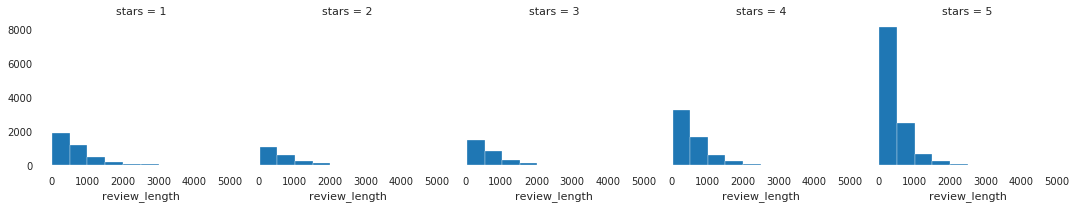

In [0]:
# Look at the review lengths by star rating

import matplotlib.pyplot as plt

sns.set_style('white')
%matplotlib inline
g = sns.FacetGrid(df,col='stars')
g.map(plt.hist,'review_length')

it looks like generally people leaving 4 and 5 star reviews tend to say less

In [0]:
# Seperate reviews based on "good" and "bad"

yelpbadreviews = df[(df.stars <= 2 )]
yelpgoodreviews = df[(df.stars >= 4)]

In [0]:
# remove all columns cept text

badreviews = yelpbadreviews.text
goodreviews = yelpgoodreviews.text 

In [0]:
"""
Because we are using sample data we don't need to create samples.
The number of reviews in the full DB is huge, and would take longer to compute. 
If we did want to sample we can use this:
badreviews = badreviews.sample(frac = .001, replace = True )
goodreviews = goodreviews.sample(frac= .001, replace = True)
"""

##Tokenizing and N-grams

In [0]:
# Tokenizing function 
def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    return filtered_words

# Counting ngram function
def count_ngrams(lines, min_length=2, max_length=4):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

# Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

# Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

# Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()
        return ngrams

# for most frequent
def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-word phrase -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')

# for word cloud
def print_word_cloud(ngrams, num=5):
    """Print word cloud image plot """
    words = []
    for n in sorted(ngrams):
        for gram, count in ngrams[n].most_common(num):
            s = ' '.join(gram)
            words.append(s)
            
    cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate(' '.join(words))
    plt.figure(figsize=(20, 15))
    plt.imshow(cloud)
    plt.axis('off');
    plt.show()
    print('')

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
# Add tonekize column 

df['tokens'] = df['text'].apply(tokenize)

df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_length,tokens
609090,IfFo03nj-PQGTzTdxH8vWA,SxrGc9Qv8b_DWo6DZOeyng,FvVSy2r7_zDEhZWqLgjXNQ,3,0,2,0,The food was great no denying that. I'm trying...,2012-12-02 20:46:30,365,"[food, great, denying, trying, cut, salt, inta..."
6460377,L46X3SlvO88xtlusGr1hFg,HOzgd-a-kAiVZappPn5yGA,ERfGoZcgrmF8p89FIs9_TA,5,2,0,1,"Delivered as promised, when promised!\n Excell...",2015-01-11 18:53:04,105,"[delivered, promised, promised, excellent, cus..."
562100,EcxvP_LcXS2MGgxvNXwCwg,hmqaQ_60rCJi86ur1kYg8g,m65oi2C7b1CJM7DaXbFi-g,5,2,1,1,Came by again with a friend just to hang out. ...,2018-01-06 06:53:10,313,"[came, friend, hang, really, seem, like, fixed..."
5339718,a1q77QOPmEJK75FgdfEjDA,qAeiX_1IOEjr56QjRjaBxA,RV__lDpb_Vo4SmSL2r5ezA,5,0,1,1,I called Real Fast Auto Glass to get the winds...,2015-05-12 15:25:27,596,"[called, real, fast, auto, glass, get, windshi..."
2958710,gsPiT4oi6rdj9MZt8rfm7w,pFfZdrY_EbDlTxEwKbZl3A,YCoLBgh973QSp-OmnwMWSg,2,2,2,1,"Terrible shuttle service, pretty good service ...",2011-07-13 14:11:37,1766,"[terrible, shuttle, service, pretty, good, ser..."


Let's start with negative reviews 

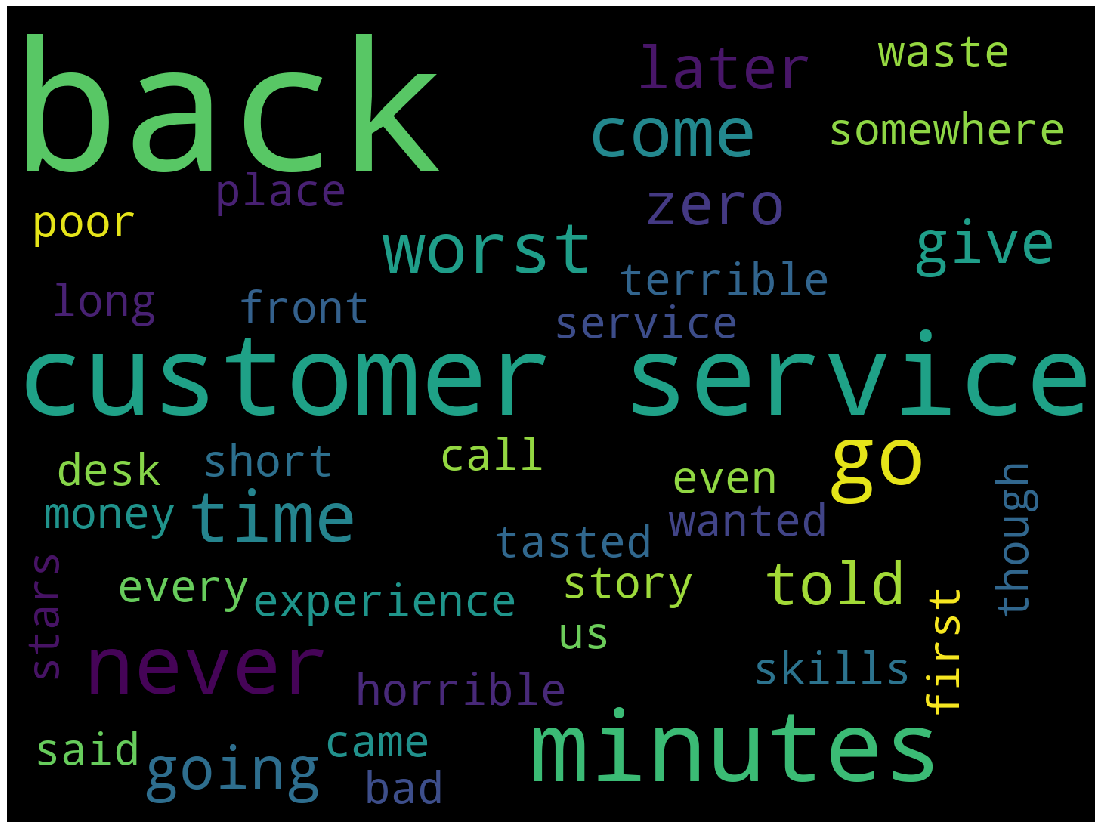

In [0]:
# Negative reviews
most_frequent_badreviews = count_ngrams(badreviews,max_length=3)
print_word_cloud(most_frequent_badreviews, 20)

In [0]:
print_most_frequent(most_frequent_badreviews, num= 20)

----- 20 most common 2-word phrase -----
customer service: 761
go back: 349
first time: 314
come back: 265
10 minutes: 230
even though: 220
15 minutes: 198
30 minutes: 182
20 minutes: 181
tasted like: 175
going back: 160
came back: 153
never go: 150
told us: 148
minutes later: 146
said would: 143
told would: 139
every time: 136
call back: 133
front desk: 132

----- 20 most common 3-word phrase -----
never go back: 105
horrible customer service: 54
poor customer service: 53
worst customer service: 47
go somewhere else: 42
never come back: 38
long story short: 36
bad customer service: 33
worst experience ever: 33
waste time money: 33
never going back: 32
terrible customer service: 31
customer service ever: 30
worst service ever: 30
10 minutes later: 26
give zero stars: 26
would come back: 25
wanted like place: 25
could give zero: 24
customer service skills: 23



Now let's look at the good 

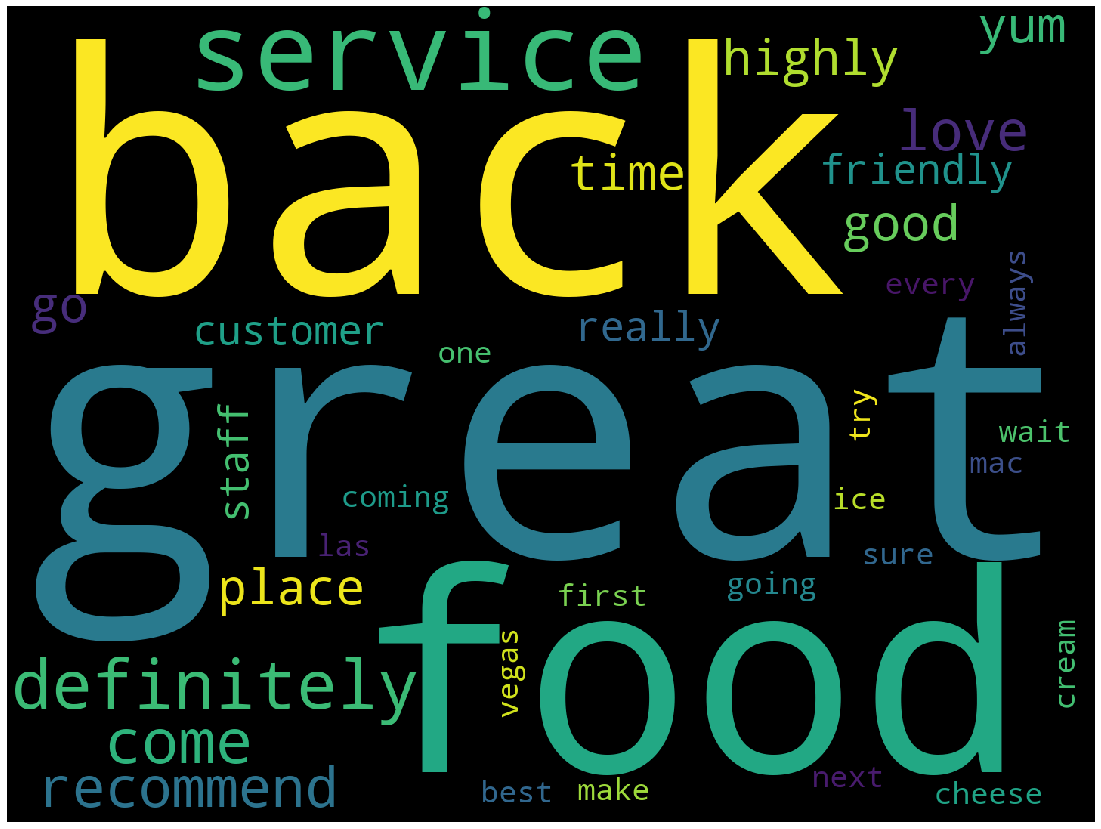

In [0]:
# Positive reviews 
most_frequent_goodreviews = count_ngrams(goodreviews,max_length=3)
print_word_cloud(most_frequent_goodreviews, 20)

In [0]:
print_most_frequent(most_frequent_goodreviews, num= 20)

----- 20 most common 2-word phrase -----
highly recommend: 986
first time: 770
customer service: 710
really good: 674
come back: 611
great service: 581
great place: 562
go back: 557
love place: 540
ice cream: 523
next time: 508
las vegas: 504
great food: 487
service great: 441
food good: 435
every time: 428
staff friendly: 426
food great: 409
one best: 406
make sure: 397

----- 20 most common 3-word phrase -----
would highly recommend: 173
definitely come back: 149
would definitely recommend: 122
great customer service: 121
highly recommend place: 116
yum yum yum: 116
definitely coming back: 108
definitely go back: 107
wait go back: 104
food great service: 94
service great food: 72
love love love: 70
great food great: 69
staff always friendly: 69
would definitely come: 68
definitely going back: 68
food really good: 67
would come back: 67
mac n cheese: 66
come back try: 64

